# Analysis for recycle scenarios

This notebook provides analysis for all of the recycle scenarios that are included in 
Amanda Bachmann's disseration. Analysis of each scenario includes the uranium resoucre, 
SWU capacity and the amount of waste disposed. 

Scenarios are numbered as follows:
* Scenario 14: Limited reycle of all fuel, no energy growth
* Scenario 15: Limited recycle of non-TRISO fuel, no energy growth
* Scenario 16: Continuous recycle, no energy growth
* Scenario 17: Limited recycle of all fuel, 1% eergy growth
* Scenario 18: Limited recycle of non-TRISO fuel, 1% energy growth
* Scenario 19: Continuos recycle, 1% energy growth

In [14]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("../../../scripts")
import dataframe_analysis as dfa
import output_metrics as oup

In [15]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.1975, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5','s2','s6','s7','s4','s3']
plotting_order_1percent = ['s11','s08','s12','s13','s10','s09']
colors = {'s14':'tab:orange', 's15':'tab:purple','s16':'tab:brown',
                   's17':'tab:orange', 's18':'tab:purple','s19':'tab:brown'}
lines = {'s14':(0,(3,5,1)), 's15':(0,(5,3)),'s16':'-.',
                's17':(0,(3,5,1)), 's18':(0,(5,3)),'s19':'-.',}
labels = {'s14':'Scenario 14', 's15':'Scenario 15', 's16':'Scenario 16', 's17':'Scenario 17',
         's18':'Scenario 18', 's19':'Scenario 19'}
legend_order = [1, 5, 4, 0, 2, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}
uox_commodity = {'LWR':'fresh_uox', 'MMR':'fresh_MMR_uox',
                   'Xe-100':'fresh_xe100_uox', 'VOYGR':'fresh_smr_uox'}
mox_commodity = {'Xe-100':'fresh_xe100_mox', 'VOYGR':'fresh_smr_mox'}

#Time period
time = np.linspace(2025, 2089, 65)

## No growth demand

In [20]:
out_files = {'s14':'../outputs/scenario_14.sqlite'}

### Fuel Mass

In [21]:
transactions_nogrowth = {'s14':'', 's15':'', 's16':''}
total_fuel_nogrowth = {'s14':'', 's15':'', 's16':''}

for scenario in ['s14']:
    transactions_nogrowth[scenario] = oup.add_receiver_prototype(out_files[scenario])

In [22]:
# Divide up fuel mass by prototype
uranium_to_reactors = {'s14_MMR':'', 's14_Xe-100':'', 's14_VOYGR':'', 's14_LWR':''}
mox_to_reactors = {'s14_Xe-100':'', 's14_VOYGR':''}

for key in uranium_to_reactors:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors[key] = dfa.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                       'fresh_uox',adv_rxs)
    else:
        uranium_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                       uox_commodity[reactor], reactor)
        uranium_to_reactors[key]['Quantity'] = uranium_to_reactors[key]['Quantity']*uranium_fractions[reactor]
    if reactor == 'Xe-100' or reactor == 'VOYGR':
            mox_to_reactors[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario],
                                                     mox_commodity[reactor], reactor)

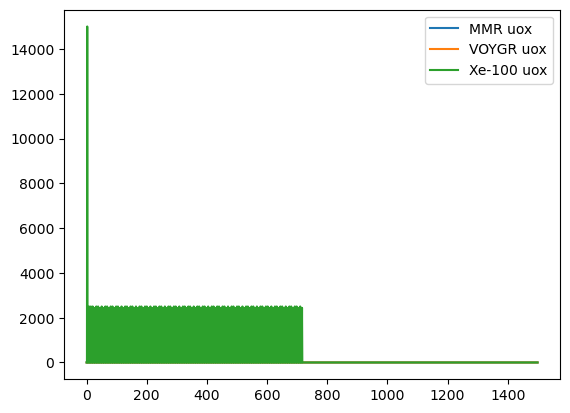

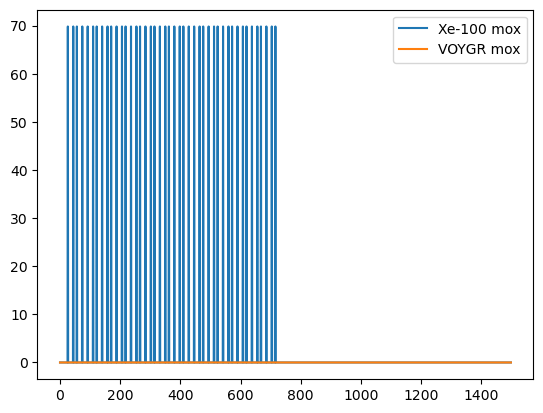

In [23]:
plt.figure()
for reactor in ['MMR','VOYGR','Xe-100']:
    plt.plot(uranium_to_reactors['s14_' + reactor]['Quantity'], label = (reactor+' uox'))
plt.legend()

plt.figure()
for reactor in ['Xe-100','VOYGR']:
    plt.plot(mox_to_reactors['s14_' + reactor]['Quantity'], label = (reactor+' mox'))
plt.legend()

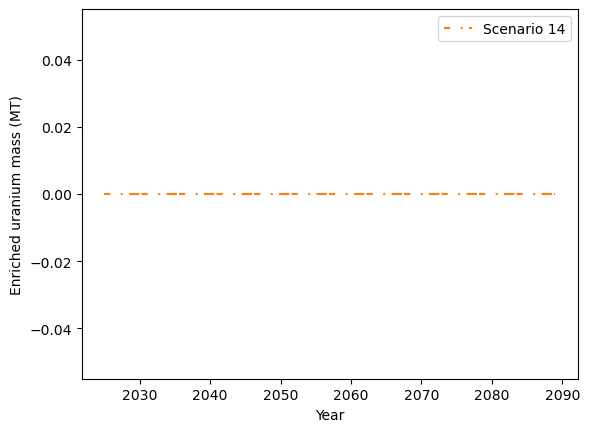

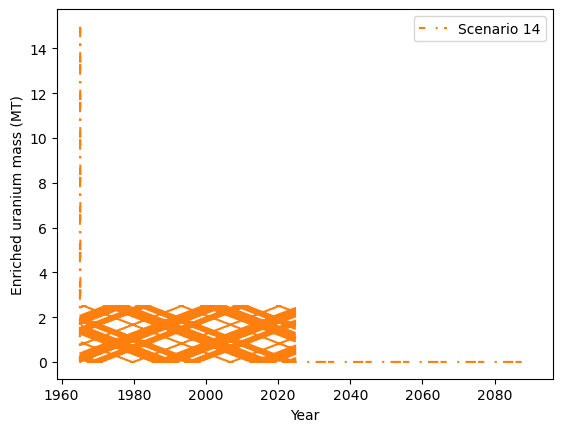

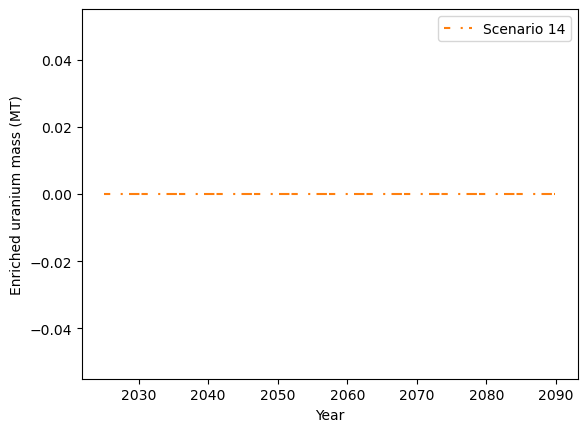

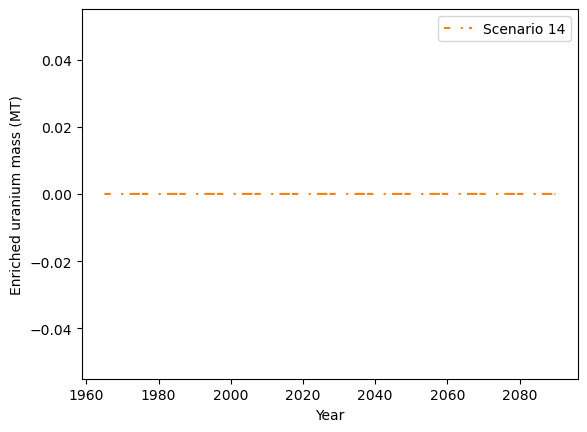

In [19]:
for key in ['s14']:
    AR_uranium = uranium_to_reactors[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors[key + '_' + reactor]['Quantity']
    averages = []
    counter = 721
    for ii in range(0, 65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter +=12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key], 
            color =colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    total_uranium = AR_uranium['Quantity'] + uranium_to_reactors[key + '_LWR']['Quantity']
    plt.figure(1)
    plt.plot(uranium_to_reactors[key + '_MMR']['Year'], total_uranium/1000, 
            label = labels[key], color = colors[key], linestyle=lines[key]) 
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    plt.figure()
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()
    
    total_mox = mox_to_reactors[key+'_Xe-100']['Quantity'] + mox_to_reactors[key+'_Xe-100']['Quantity']
    plt.figure()
    plt.plot(mox_to_reactors[key+'_Xe-100']['Year'], total_mox,
            label=labels[key], color=colors[key], linestyle = lines[key])
    plt.xlabel('Year')
    plt.ylabel('Enriched uranium mass (MT)')
    plt.legend()

### Feed Uranium 

In [30]:
tails = {'s14_MMR':'', 's14_VOYGR':'', 's14_Xe-100':'', 's14_LWR':''}
feed = {'s14_MMR':'', 's14_VOYGR':'', 's14_Xe-100':'', 's14_LWR':''}
SWU = {'s14_MMR':'', 's14_VOYGR':'', 's14_Xe-100':'', 's14_LWR':''}

for key in tails:
    reactor = key[4:]
    tails[key] = dfa.calculate_tails(uranium_to_reactors[key]['Quantity'],
                                    assays[reactor], assays['tails'], assays['feed'])
    feed[key] = dfa.calculate_feed(uranium_to_reactors[key]['Quantity'],
                                  tails[key])
    SWU[key] = dfa.calculate_SWU(uranium_to_reactors[key]['Quantity'], assays[reactor],
                                tails[key], assays['tails'], feed[key], assays['feed'])

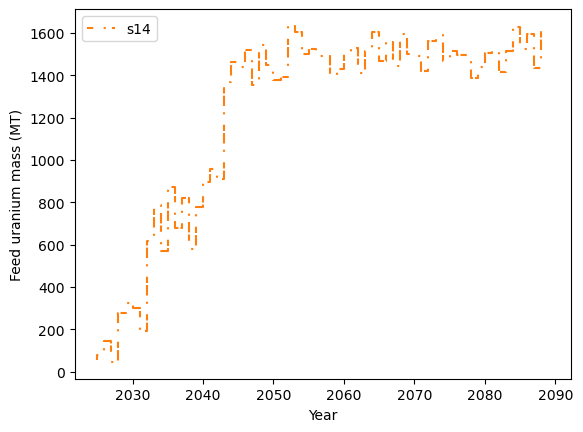

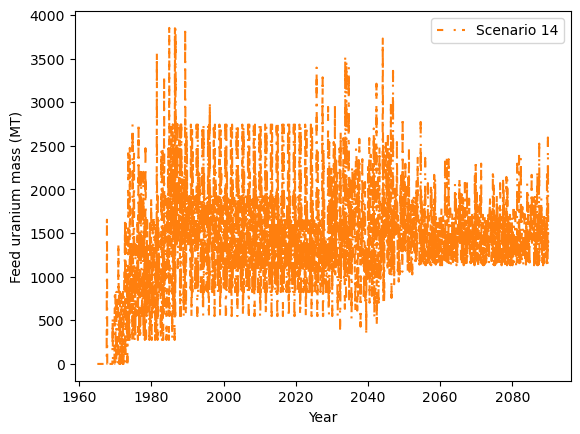

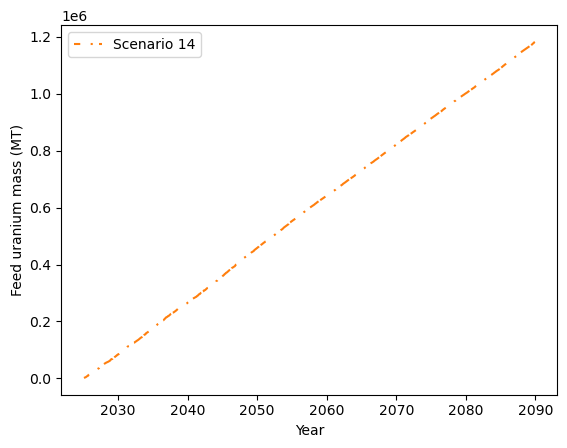

In [31]:
for key in ['s14']:
    AR_feed = feed[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=key,
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    total_feed = AR_feed + feed[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors[key + '_MMR']['Year'], total_feed/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()
    
    plt.figure(2)
    plt.plot(uranium_to_reactors[key + '_MMR']['Year'][721:], total_feed[721:].cumsum()/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Feed uranium mass (MT)')
    plt.legend()

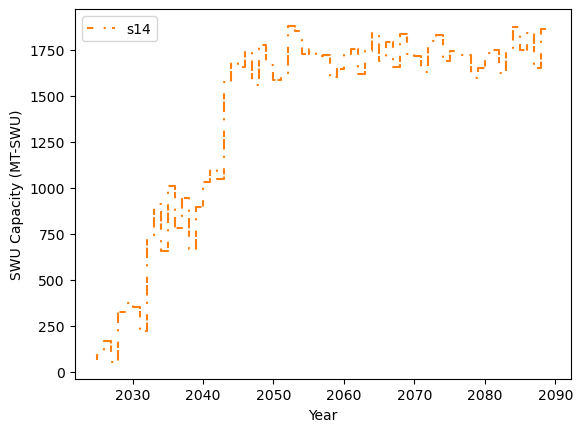

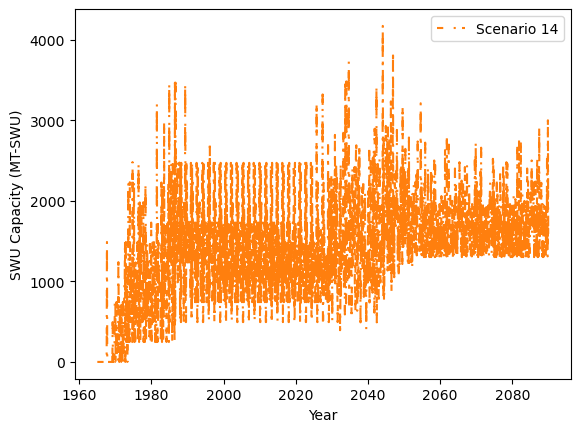

In [32]:
for key in ['s14']:
    AR_swu = SWU[key + '_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_swu += SWU[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0, 65):
        year_data = AR_swu[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
        
    plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=key,
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()
    
    total_swu = AR_swu + SWU[key + '_LWR']
    plt.figure(1)
    plt.plot(uranium_to_reactors[key + '_MMR']['Year'], total_swu/1000,
            label=labels[key], color = colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('SWU Capacity (MT-SWU)')
    plt.legend()

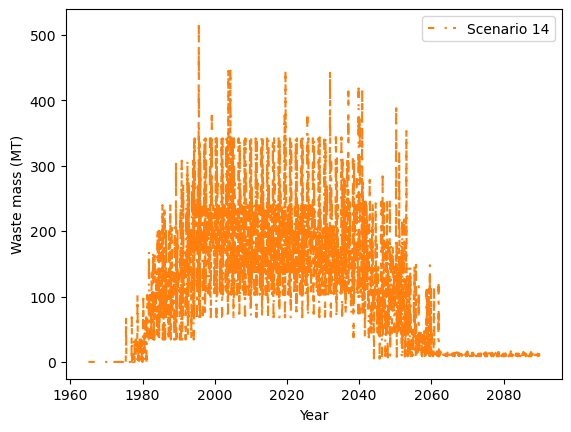

In [33]:
### Waste mass -- disposed of in HLW Sink

waste = {'s14':''}
for key in waste:
    waste[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                       'separated_waste', 'Sink_HLW')
    waste[key]['Quantity'] += dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                       'casked_spent_fuel', 'Sink_HLW')['Quantity']
    plt.figure(0)
    plt.plot(waste[key]['Year'], waste[key]['Quantity']/1000, label=labels[key],
            color=colors[key], linestyle=lines[key])
    plt.xlabel('Year')
    plt.ylabel('Waste mass (MT)')
    plt.legend()

In [57]:
dictionary = {'spent_uox':40, 'spent_mox':44}
out_commods = ['spent_mox', 'spent_uox']

In [3]:
def discharge(jj):
    if jj == 5:
        return False
    else:
        jj -= 1
        return True

In [8]:
jj = 9
if 0 == 0:
    while jj >0:
        print(jj, discharge(jj))
        jj -= 1
        if discharge(jj) == False:
            break

9 True
8 True
7 True
6 True


In [9]:
indexes = {4:1,6:1,8:1}


In [10]:
indexes.pop(4)

1

In [11]:
indexes

{6: 1, 8: 1}